# setup

In [1]:
if True:
    import mysql.connector as mysql_connector

import os
import sys
from collections import defaultdict
from datetime import date, datetime
from typing import Any, DefaultDict, Dict, List

import dotenv
import matplotlib.pyplot as plt
import pandas
from tqdm.notebook import tqdm

dotenv.load_dotenv()

True

In [2]:
%load_ext autoreload
%autoreload 2

# mysql

In [3]:
import sys

sys.path.append("../")

In [4]:
%reload_ext autoreload

from crunch_global_leaderboard._database import Database

if "database" in globals():
    database.__exit__(None, None, None) # type: ignore

database = Database(
    host=os.environ["DATABASE_HOST"],
    user=os.environ["DATABASE_USER"],
    password=os.environ["DATABASE_PASSWORD"],
    account_service_name=os.environ["ACCOUNT_DATABASE_NAME"],
    competition_service_name=os.environ["COMPETITION_DATABASE_NAME"],
    enable_caching=False,
)

database.__enter__()

In [5]:
%reload_ext autoreload

from crunch_global_leaderboard._repository import LoadEverythingRepository

repository = LoadEverythingRepository(database)

  0%|          | 0/18 [00:00<?, ?method/s]

load: universities
load: competitions
load: users
load: leaderboard_definitions
load: targets
load: rounds
load: phases
load: crunches
load: crunch_targets
load: leaderboards
load: positions
load: paid_checkpoint_payouts
load: legacy_leaderboard_entries
load: participants
load: institutions
load: global_leaderboards
load: teams
load: submissions


  0%|          | 0/14338 [00:00<?, ?it/s]

0it [00:00, ?it/s]

len: _university_by_display_name=9817
len: _competitions=16
len: _users=1979
len: _user_by_id=1979
len: _user_by_login=1979
len: _default_leaderboard_definition_by_competition_id=17
len: _usable_targets_by_competition_id=18
len: _rounds_by_competition_id=17
len: _phases_by_round_id=99
len: _crunches_by_phase_id=191
len: _crunch_target_by_crunch_id_and_target_id=816
len: _leaderboard_by_crunch_target_id_and_leaderboard_definition_id=561
len: _position_by_leaderboard_id_and_user_id=54472
len: _best_team_rank_by_leaderboard_id_and_team_id=1524
len: _payouts_by_competition_id=1
len: _payout_recipient_by_payout_id_and_user_id=207
len: _legacy_leaderboard_entries_by_user_id=553
len: _participants_by_user_id=8396
len: _institution_by_name=399
len: _institution_by_id=399
len: _user_ids_by_institution_id=399
len: _global_leaderboard_by_date=1
len: _teams_by_competition_id=7
len: _team_members_by_team_id=401
len: _team_by_competition_id_and_user_id=822
len: _submission_count_per_user_per_date=10

### repository testing

In [5]:
repository._submission_count_per_user_per_date[min(*repository._submission_count_per_user_per_date.keys())]

{42: 1, 30: 1, 12: 1, 14: 1, 18: 1, 10: 1, 34: 1}

<Axes: xlabel='date'>

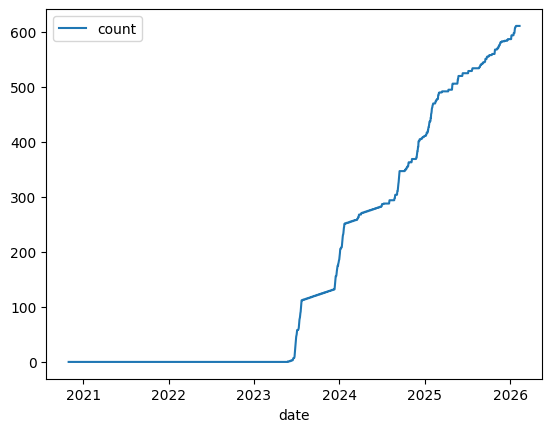

In [6]:
user_id = repository.find_user_by_login("tarandros")["id"]

pandas.DataFrame({
    "date": repository._submission_count_per_user_per_date.keys(),
    "count": [
        count_per_user_id.get(user_id, 0)
        for count_per_user_id in repository._submission_count_per_user_per_date.values()
    ]
}).sort_values("date").plot(x="date", y="count", kind="line")

# querying common data

In [6]:
user = repository.find_user_by_login("tarandros")
user = repository.find_user_by_login("smoggy-mahcih")
user = repository.find_user_by_id(10996)

user["id"]

10996

In [7]:
competitions = repository.find_all_competitions()

structural_break2 = next(filter(lambda x: x["name"] == "structural-break-open-benchmark", competitions), None)
if structural_break2 is not None:
    competitions.remove(structural_break2)

for competition in competitions:
    print(competition["name"])

datacrunch-legacy
adialab
datacrunch
venture-capital-portfolio-prediction
datacrunch-rally
causality-discovery
mid-one
broad-1
broad-2
broad-3
structural-break
falcon
broad-obesity-1
datacrunch-2
synth


In [8]:
datacrunch_legacy = next(filter(lambda x: x["name"] == "datacrunch-legacy", competitions))
structural_break = next(filter(lambda x: x["name"] == "structural-break", competitions))
datacrunch = next(filter(lambda x: x["name"] == "datacrunch", competitions))
falcon = next(filter(lambda x: x["name"] == "falcon", competitions))

# compute events

In [9]:
%reload_ext autoreload

from crunch_global_leaderboard.__init__ import _compute_events # pyright: ignore[reportPrivateUsage]
from crunch_global_leaderboard._utility import group_by

(
    all_events_by_user_id,
) = _compute_events(
    users=[user],
    competitions=competitions,
    repository=repository,
)

all_events = all_events_by_user_id[user["id"]]

for competition_name, events in group_by(all_events, key=lambda x: x["competition"]["name"]).items():
    print(competition_name, len(events))

  0%|          | 0/1 [00:00<?, ?user/s]

falcon 8


## demo

<Axes: xlabel='month'>

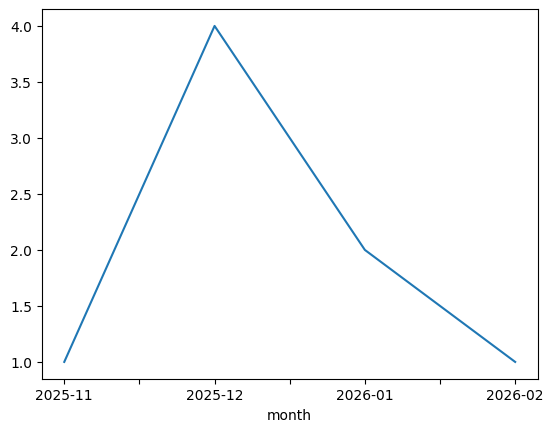

In [10]:
df = pandas.DataFrame(all_events)
df["month"] = df["start"].astype(str).str[:7]
df.groupby("month")["rank"].count().plot()

# compute all dates

In [11]:
start_date = date.fromisoformat("2023-05-16")
end_date = date.today()

dates = list(map(datetime.date, pandas.date_range(start_date, end_date, freq="D")))

  0%|          | 0/1013 [00:00<?, ?it/s]

(<Axes: >, 1013, 654000.0)

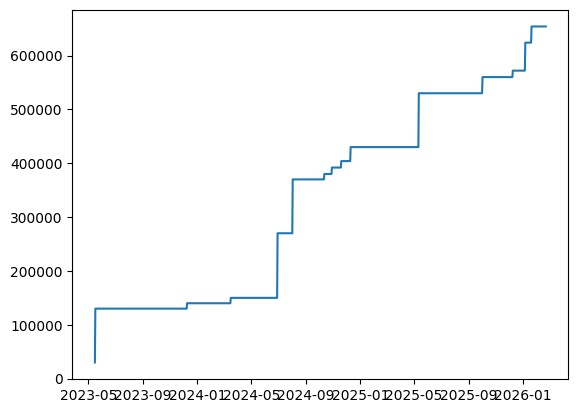

In [12]:
sum_payouts_by_date = {
    date: sum((
        competition["prize_pool_usd"]
        for competition in competitions
        if competition["start"].date() < date
    ))
    for date in tqdm(dates)
}

pandas.Series(sum_payouts_by_date).plot(), len(sum_payouts_by_date), sum_payouts_by_date[dates[-1]]

# compute_raw_points

In [13]:
%reload_ext autoreload

from crunch_global_leaderboard._point import compute_raw_points

for event in all_events:
    compute_raw_points(event)

## test

<Axes: xlabel='start'>

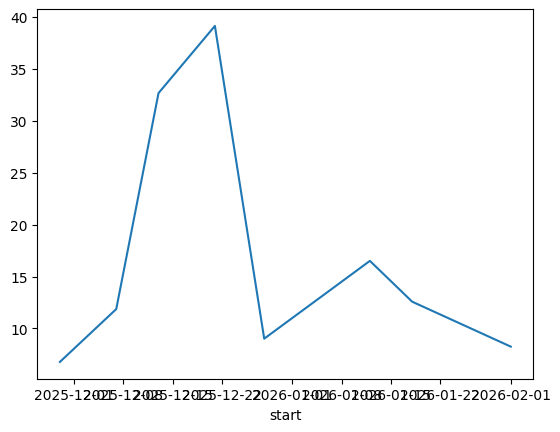

In [14]:
df = pandas.DataFrame(all_events)
df[["start", "raw_points"]].set_index("start", drop=True).sort_index()["raw_points"].plot()

<Axes: xlabel='start'>

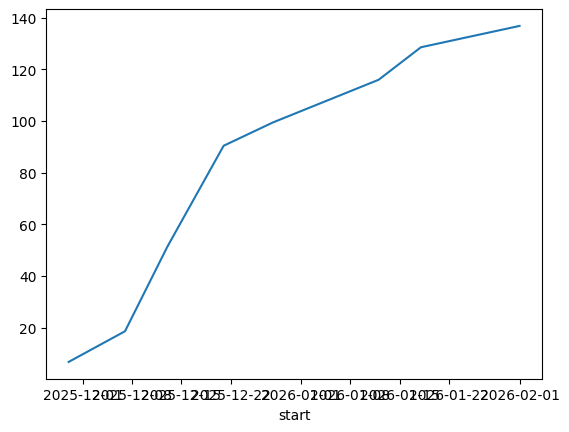

In [15]:
df = pandas.DataFrame(all_events)
# df = df[[event["competition"]["name"] == "datacrunch-legacy" for event in all_events]]
df[["start", "raw_points"]].set_index("start", drop=True).sort_index()["raw_points"].cumsum().plot()

# compute_decayed_points

  0%|          | 0/1013 [00:00<?, ?it/s]

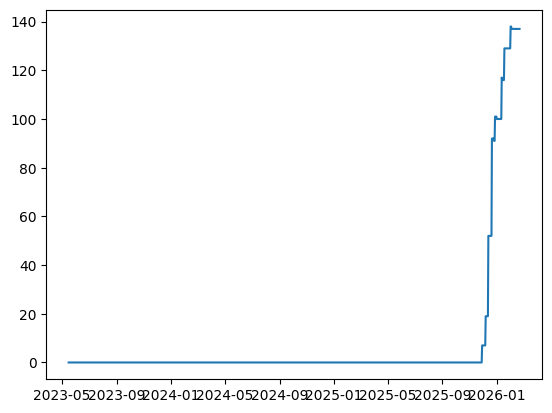

In [16]:
%reload_ext autoreload

from crunch_global_leaderboard._point import PointParameters, compute_decayed_points

PointParameters.DECAY_CONSTANT = 1500

points_per_day: Dict[date, int] = {}
events_count_per_day: Dict[date, int] = {}

for event in all_events:
    event["decayed_count"] = 0

for today in tqdm(dates):
    events = [
        event
        for event in all_events
        if today >= event["start"]
    ]

    # print(today, len(events))

    for event in events:
        compute_decayed_points(event, today)
    
    points_per_day[today] = sum((
        event["decayed_points"]
        for event in events
    ))
    
    events_count_per_day[today] = len(events)

ax = pandas.Series(points_per_day).plot()

# for event in all_events:
#     if event["phase"]["type"] == "OUT_OF_SAMPLE":
#         ax.axvline(event["date"], color="red", linestyle="--")

<Axes: >

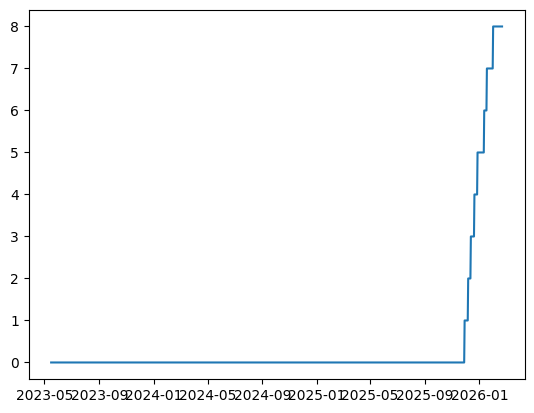

In [17]:
pandas.Series(events_count_per_day).plot()

# compute for all users

In [18]:
all_users = repository.find_all_users()

len(all_users)

1979

In [19]:
%reload_ext autoreload

from crunch_global_leaderboard.__init__ import _compute_events  # type: ignore

(
    all_events_by_user_id,
) = _compute_events(
    users=all_users,
    competitions=competitions,
    repository=repository,
)

point_entries: List[Dict[str, Any]] = []

test_date = date.fromisoformat("2024-07-06")
for user_id, events in tqdm(all_events_by_user_id.items(), total=len(all_events_by_user_id)):
    total_points_per_competitions: DefaultDict[str, int] = defaultdict(lambda: 0)
    total_points: int = 0

    for event in events:
        # if event["date"] > test_date:
        #     continue

        compute_decayed_points(event, test_date)

        points = int(event["raw_points"])
        # points = int(event["decayed_points"])

        key = event["competition"]["name"]
        # key = event["competition"]["name"] + "." + event["target"]["name"]

        total_points_per_competitions[key] += points
        total_points += points

    point_entries.append({
        "user.id": user_id,
        "user.login": repository.find_user_by_id(user_id)["login"],
        "total": total_points,
        **total_points_per_competitions,
    })

point_entries_df = pandas.DataFrame(point_entries)
point_entries_df.head(3)

  0%|          | 0/1979 [00:00<?, ?user/s]

  0%|          | 0/1979 [00:00<?, ?it/s]

,user.id,user.login,total,adialab,datacrunch,venture-capital-portfolio-prediction,mid-one,broad-3,structural-break,broad-obesity-1,datacrunch-2,datacrunch-legacy,datacrunch-rally,causality-discovery,falcon,broad-1,broad-2
0,1,enzo,239,0.0,5.0,4.0,88.0,41.0,7.0,94.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,happy-mike,759,46.0,402.0,NaN,NaN,NaN,40.0,30.0,0.0,54.0,4.0,183.0,NaN,NaN,NaN
2,9,tmarx,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
top_15 = point_entries_df.sort_values(by=["total"], ascending=False).head(25)
top_15.head(3)

,user.id,user.login,total,adialab,datacrunch,venture-capital-portfolio-prediction,mid-one,broad-3,structural-break,broad-obesity-1,datacrunch-2,datacrunch-legacy,datacrunch-rally,causality-discovery,falcon,broad-1,broad-2
512,3048,tarandros,32187,13851.0,1868.0,714.0,850.0,1256.0,1698.0,154.0,1.0,400.0,159.0,7985.0,54.0,560.0,2637.0
677,4009,smoggy-mahcih,18723,63.0,1997.0,321.0,241.0,NaN,NaN,NaN,NaN,NaN,236.0,15454.0,411.0,NaN,NaN
1568,9941,rafael,13169,NaN,NaN,NaN,NaN,NaN,13169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Figure size 1200x800 with 0 Axes>

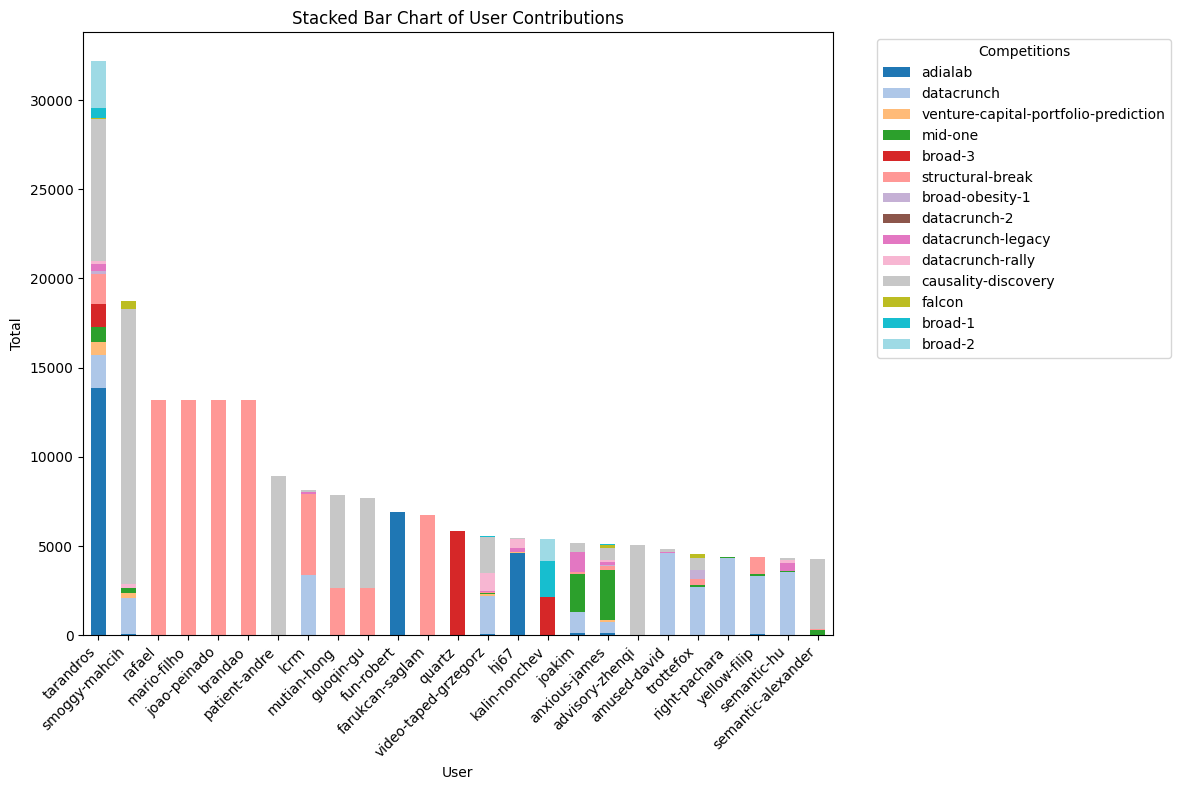

In [21]:
df = top_15
df = df[df['total'] > 0]

del df["user.id"]
del df["total"]
df.set_index('user.login', inplace=True)

plt.figure(figsize=(12, 8))
df.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 8))

plt.title('Stacked Bar Chart of User Contributions')
plt.xlabel('User')
plt.ylabel('Total')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Competitions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

## sum points per user

In [22]:
df = point_entries_df
df = df[df['total'] > 0].copy()

del df["user.id"]
df.set_index('user.login', inplace=True)

df.sort_values(by=["total"], ascending=False, inplace=True)

total = df["total"] / df["total"].sum()
total.index.name = "--- Ordered by User Size"
display((total / total.sum() * 100).sort_values(ascending=False))

--- Ordered by User Size
tarandros              5.425428
smoggy-mahcih          3.155941
rafael                 2.219761
mario-filho            2.218581
brandao                2.218581
                         ...   
tags                   0.000169
kinich-ahau            0.000169
technological-luigi    0.000169
samu2505               0.000169
profound-oskar         0.000169
Name: total, Length: 1463, dtype: float64

In [24]:
logins = [
    "enzo",
    "happy-mike",
    "xgilbert",
    "doriansu",
    "tarandros",
    "smoggy-mahcih",
    user["login"]
]

for login in logins:
    print(f"{login:15}", f"{total[login] * 1_000_000:12.4f}")

enzo                402.8574
happy-mike         1279.3673
xgilbert           1294.5377
doriansu            165.1884
tarandros         54254.2755
smoggy-mahcih     31559.4122
guhan               224.1843


## sum points per competition

In [28]:
total = point_entries_df.sum()
del total["user.id"]
del total["user.login"]
del total["total"]

total.index.name = "--- Ordered by Competition Size"
display((total / total.sum() * 100).sort_values(ascending=False))

total.index.name = "--- Ordered by Competition Name"
display((total / total.sum() * 100).sort_index())

--- Ordered by Competition Size
structural-break                        25.593007
causality-discovery                     22.712194
datacrunch                              16.095597
adialab                                 15.968788
datacrunch-legacy                        4.109499
broad-3                                  3.652506
broad-1                                  2.652661
mid-one                                  2.496258
broad-2                                  1.854815
venture-capital-portfolio-prediction     1.665032
datacrunch-rally                         1.639567
broad-obesity-1                          0.949259
falcon                                   0.605482
datacrunch-2                             0.005334
dtype: object

--- Ordered by Competition Name
adialab                                 15.968788
broad-1                                  2.652661
broad-2                                  1.854815
broad-3                                  3.652506
broad-obesity-1                          0.949259
causality-discovery                     22.712194
datacrunch                              16.095597
datacrunch-2                             0.005334
datacrunch-legacy                        4.109499
datacrunch-rally                         1.639567
falcon                                   0.605482
mid-one                                  2.496258
structural-break                        25.593007
venture-capital-portfolio-prediction     1.665032
dtype: object

In [29]:
total = point_entries_df.sum()
del total["user.id"]
del total["user.login"]
del total["total"]

total.index.name = "--- Ordered by Competition Name"
display(total.sort_index())

--- Ordered by Competition Name
adialab                                  92809.0
broad-1                                  15417.0
broad-2                                  10780.0
broad-3                                  21228.0
broad-obesity-1                           5517.0
causality-discovery                     132001.0
datacrunch                               93546.0
datacrunch-2                                31.0
datacrunch-legacy                        23884.0
datacrunch-rally                          9529.0
falcon                                    3519.0
mid-one                                  14508.0
structural-break                        148744.0
venture-capital-portfolio-prediction      9677.0
dtype: object

# insert in database

In [30]:
database.competition.insert("SET FOREIGN_KEY_CHECKS = 0;")
database.competition.insert("TRUNCATE `institution_members`;")
database.competition.insert("TRUNCATE `institutions`;")
database.competition.insert("SET FOREIGN_KEY_CHECKS = 1;")

0

In [31]:
database.commit()

In [33]:
repository.load(only=["institutions"])

  0%|          | 0/18 [00:00<?, ?method/s]

load: institutions
len: _university_by_display_name=9817
len: _competitions=15
len: _users=1667
len: _user_by_id=1667
len: _user_by_login=1667
len: _default_leaderboard_definition_by_competition_id=16
len: _usable_targets_by_competition_id=17
len: _rounds_by_competition_id=16
len: _phases_by_round_id=96
len: _crunches_by_phase_id=186
len: _crunch_target_by_crunch_id_and_target_id=803
len: _leaderboard_by_crunch_target_id_and_leaderboard_definition_id=546
len: _position_by_leaderboard_id_and_user_id=53273
len: _best_team_rank_by_leaderboard_id_and_team_id=1421
len: _payouts_by_competition_id=1
len: _payout_recipient_by_payout_id_and_user_id=189
len: _legacy_leaderboard_entries_by_user_id=553
len: _participants_by_user_id=8303
len: _institution_by_name=0
len: _institution_by_id=0
len: _user_ids_by_institution_id=0
len: _global_leaderboard_by_date=100
len: _teams_by_competition_id=7
len: _team_members_by_team_id=393
len: _team_by_competition_id_and_user_id=809
len: _submission_count_per_u

## compute events

In [34]:
%reload_ext autoreload

from crunch_global_leaderboard.__init__ import _compute_events  # pyright: ignore[reportPrivateUsage]

(
    all_events_by_user_id,
) = _compute_events(
    users=all_users,
    competitions=competitions,
    repository=repository,
)

  0%|          | 0/1667 [00:00<?, ?user/s]

## compute participations

In [35]:
%reload_ext autoreload

from crunch_global_leaderboard.__init__ import _compute_participations  # pyright: ignore[reportPrivateUsage]

(
    participation_count_per_date_per_user_id,
) = _compute_participations(
    dates=dates,
    users=all_users,
    repository=repository,
)

  0%|          | 0/1667 [00:00<?, ?user/s]

# compute institutions

In [36]:
%reload_ext autoreload

from crunch_global_leaderboard.__init__ import _compute_institutions  # pyright: ignore[reportPrivateUsage]

(
    institution_by_user_id,
    created_institution_count,
) = _compute_institutions(
    all_events_by_user_id=all_events_by_user_id,
    repository=repository,
    skip_university_description=True,
)

print(f"created_institution_count={created_institution_count}")

  0%|          | 0/1667 [00:00<?, ?it/s]

  0%|          | 0/398 [00:00<?, ?it/s]

created_institution_count=398


In [37]:
database.commit()

## compute (and insert) user positions

In [38]:
database.competition.insert("SET FOREIGN_KEY_CHECKS = 0;")
database.competition.insert("TRUNCATE `global_user_positions`;")
database.competition.insert("TRUNCATE `global_institution_positions`;")
database.competition.insert("TRUNCATE `global_leaderboards`;")
database.competition.insert("TRUNCATE `institution_participations`;")
database.competition.insert("SET FOREIGN_KEY_CHECKS = 1;")

0

In [39]:
database.commit()

In [40]:
repository.load(only=["global_leaderboards"])

  0%|          | 0/18 [00:00<?, ?method/s]

load: global_leaderboards
len: _university_by_display_name=9817
len: _competitions=15
len: _users=1667
len: _user_by_id=1667
len: _user_by_login=1667
len: _default_leaderboard_definition_by_competition_id=16
len: _usable_targets_by_competition_id=17
len: _rounds_by_competition_id=16
len: _phases_by_round_id=96
len: _crunches_by_phase_id=186
len: _crunch_target_by_crunch_id_and_target_id=803
len: _leaderboard_by_crunch_target_id_and_leaderboard_definition_id=546
len: _position_by_leaderboard_id_and_user_id=53273
len: _best_team_rank_by_leaderboard_id_and_team_id=1421
len: _payouts_by_competition_id=1
len: _payout_recipient_by_payout_id_and_user_id=189
len: _legacy_leaderboard_entries_by_user_id=553
len: _participants_by_user_id=8303
len: _institution_by_name=398
len: _institution_by_id=398
len: _user_ids_by_institution_id=398
len: _global_leaderboard_by_date=0
len: _teams_by_competition_id=7
len: _team_members_by_team_id=393
len: _team_by_competition_id_and_user_id=809
len: _submission_

In [44]:
%reload_ext autoreload

from crunch_global_leaderboard._constants import PointParameters

PointParameters.DECAY_CONSTANT

1500

In [43]:
%reload_ext autoreload

# PointParameters.DECAY_CONSTANT = 100

  0%|          | 0/100 [00:00<?, ?date/s]

<Axes: >

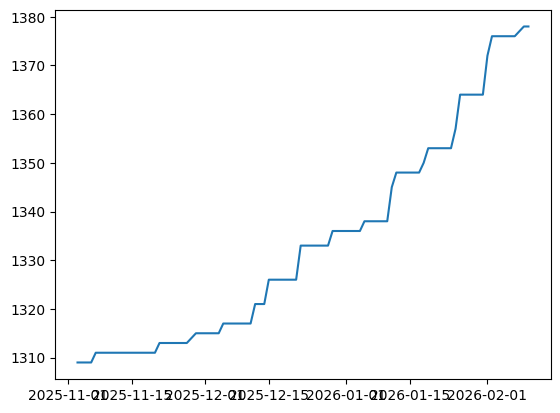

In [45]:
%reload_ext autoreload

from crunch_global_leaderboard.__init__ import _compute_user_postitions # type: ignore

(
    user_positions_per_date,
) = _compute_user_postitions(
    # dates=dates,
    dates=dates[-100:],
    users=all_users,
    all_events_by_user_id=all_events_by_user_id,
    institution_by_user_id=institution_by_user_id,
    participation_count_per_date_per_user_id=participation_count_per_date_per_user_id,
    repository=repository,
)

pandas.Series({
    key: len(value)
    for key, value in user_positions_per_date.items()
}).plot()

In [46]:
database.commit()

## visualization

In [47]:
user2 = repository.find_user_by_login("tarandros")
user2 = repository.find_user_by_login("xgilbert")
rows = database.competition.query_many(f"""
    SELECT
        `leaderboard`.`date`,
        `position`.`rank`,
        `position`.`points`,
        `position`.`best_rank` AS `bestRank`,
        `position`.`participation_count` AS `participationCount`,
        `position`.`submission_count` AS `submissionCount`
    FROM `global_user_positions` AS `position`
    LEFT JOIN `global_leaderboards` AS `leaderboard` ON `leaderboard`.`id` = `position`.`leaderboard_id`
    WHERE
        `position`.`user_id` = {user2['id']}
""")

points = pandas.DataFrame(rows, columns=["date", "rank", "points", "bestRank", "participationCount", "submissionCount"])
points.set_index("date", drop=True, inplace=True)

len(points)

100

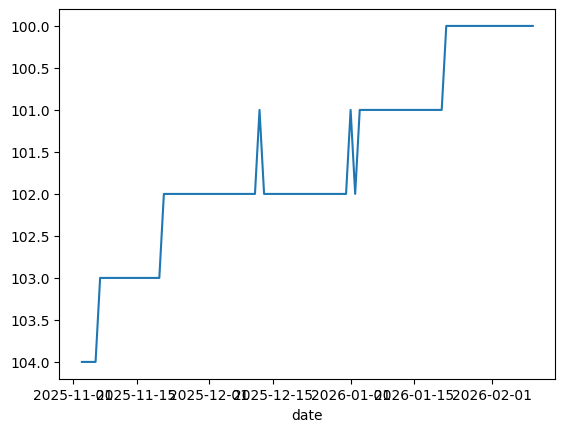

In [48]:
points["rank"].plot()
plt.gca().invert_yaxis()

<Axes: xlabel='date'>

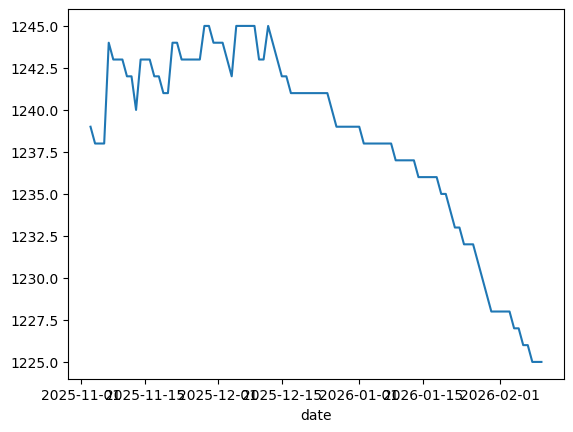

In [49]:
points["points"].plot()

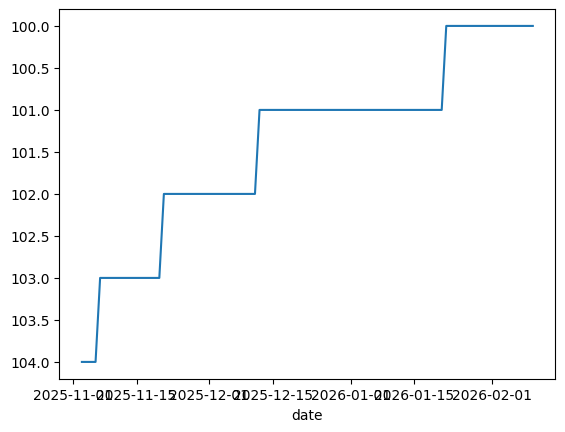

In [50]:
points["bestRank"].plot()
plt.gca().invert_yaxis()

<Axes: xlabel='date'>

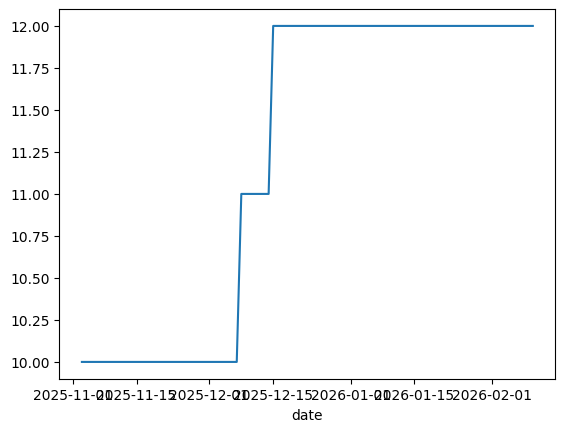

In [51]:
points["participationCount"].plot()

<Axes: xlabel='date'>

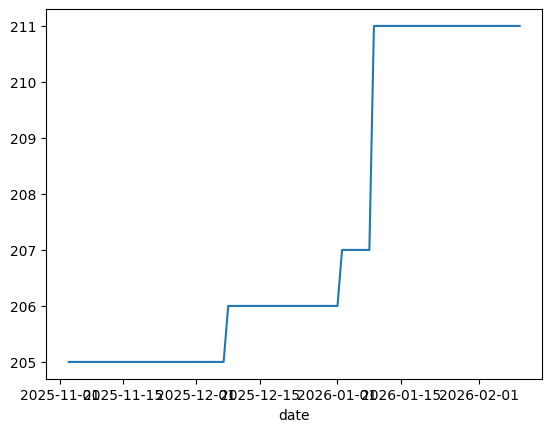

In [52]:
points["submissionCount"].plot()

# description rephrasing

In [53]:
from crunch_global_leaderboard._web import get_site_description


def demo(name: str):
    university = repository.find_first_university_by_display_name(name)
    assert university

    url = university["url"]
    assert url

    description = get_site_description(url, quiet=True)

    print("Name:", university["name"])
    print("URL:", university["url"])
    print("Country:", university["country_alpha3"])
    print("Website Description:", description)


# demo("Universidade Federal de Alfenas")
demo("Universidade Federal de Minas Gerais")

Name: Universidade Federal de Minas Gerais
URL: https://www.ufmg.br
Country: BRA
Website Description: Liderança regional e nacional em ensino superior gratuito, extensão, cultura, pesquisa científica e geração de patentes em todas as áreas do conhecimento


In [ ]:
from openai import OpenAI

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
openai_client = OpenAI(
    api_key=OPENAI_API_KEY,
)

In [55]:
from crunch_global_leaderboard._web import rephrase_description


def demo(name: str):
    university = repository.find_first_university_by_display_name(name)
    assert university

    url = university["url"]
    assert url

    description = get_site_description(url, quiet=True)
    assert description

    rephrased_description = rephrase_description(
        university=university,
        description=description,
        openai_client=openai_client,
    )

    display(f"{university['name']}: {rephrased_description}")


demo("Universidade Federal de Alfenas")
demo("Universidade Federal de Minas Gerais")
demo("University of California, Berkeley")
demo("Universidade Federal do Rio Grande do Sul")
demo("Indian Institute of Technology, Madras")

'Universidade Federal de Alfenas: A university in Brazil offering undergraduate and postgraduate programs, with a focus on academic life, community services, and various events and opportunities.'

'Universidade Federal de Minas Gerais: A university known for regional and national leadership in free higher education, extension, culture, scientific research, and patent generation across all fields of knowledge.'

'University of California, Berkeley: A university that pushes the boundaries of knowledge, challenges convention, and expands opportunities to create future leaders.'

'Universidade Federal do Rio Grande do Sul: A university in Brazil.'

'Indian Institute of Technology, Madras: A public technical and research university in Chennai, known for providing higher education in India.'